<p align="center">
    <img src="title_img.png" width="65%" style="border-radius: 12px;">
</p>

<h1 style="text-align:center; font-family:Segoe UI, sans-serif; color:darkorange">
📈 AAPL Risk & Price Forecasting with GARCH & LSTM
</h1>

<p style="text-align:center; font-size:16px;">
A real-world stock market forecasting project using Apple Inc. (AAPL) data.  
Built with volatility modeling (GARCH), deep learning (LSTM), and robust preprocessing.  
Designed to understand risk and anticipate future prices during volatile market regimes like global tariff shocks and policy uncertainty.
</p>

<hr>

<p style="text-align:center; font-size:15px;">
<strong>Author:</strong> Abdullah Shahzad &nbsp; | &nbsp;
<a href="mailto:abdullahshahzadhunjra@gmail.com">📧 abdullahshahzadhunjra@gmail.com</a> &nbsp; | &nbsp;
<a href="https://www.linkedin.com/in/abdullahhunjra" target="_blank">🔗 LinkedIn</a> &nbsp; | &nbsp;
<a href="https://github.com/abdullahhunjra" target="_blank">💻 GitHub</a>
</p>


## 🎯 Project Objective

- Forecast **volatility (risk)** in AAPL stock using ARCH family models.
- Predict **future prices** using LSTM neural networks.
- Compare how well statistical vs. deep learning models perform under different market conditions.
- Build interpretable visuals to show model forecasts and real-world context (e.g., geopolitical shocks).


## Importing Libraries

In [16]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from arch import arch_model
from scipy.stats import t, norm

from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore", category=UserWarning)


## We will Use Different Time Horizons for ARCH Models and LSTM

In this project, we consciously use **two different spans of data** — a shorter and a larger one — based on the nature and requirements of the models being used:

We will create **two datasets** of apple stock data:

- `appl_short` → for ARCH-based volatility forecasting  
- `appl_large` → for LSTM-based price prediction  

#### 📉 Short-Term Data for Volatility Modeling (ARCH Family)

Volatility forecasting models like **ARCH/GARCH** are highly sensitive to **recent shocks and short-term fluctuations**.  
Using **too much historical data** may:

- Smooth out meaningful short-term volatility spikes  
- Dilute important signals from recent market behavior  
- Make the volatility forecast less responsive to events like policy announcements or earnings surprises

Therefore, we use a **shorter data window** (e.g., *2024-01-01 to 2025-05-31*) for models from the **ARCH family**, where local dynamics are more informative than long-term history.


#### 📈 Long-Term Data for Price Prediction (LSTM)

Price prediction models like **LSTM** are data-hungry by nature. They benefit from:

- Larger datasets to learn long-term price trends  
- Seasonal patterns or structural shifts in the market  
- Better generalization due to more training examples

So we use a **longer data window** (e.g., *2020-01-01 to 2025-06-01*) for training the LSTM model, allowing it to capture richer patterns and improve forecast accuracy.



In [33]:
# Download data (default now returns MultiIndex)
appl_short = yf.download('AAPL', start='2024-01-01', end='2025-05-31')
appl_large = yf.download('AAPL', start='2020-01-01', end='2025-06-01')

# Flatten the MultiIndex columns
appl_short.columns = appl_short.columns.get_level_values(0)
appl_large.columns = appl_large.columns.get_level_values(0)


# We fetch daily AAPL stock prices from Yahoo Finance, then renamed 'Close' to 'Price' for clarity
appl_short = appl_short.rename(columns={'Close': 'Price'})
appl_short.columns = appl_short.columns.get_level_values(0)

appl_large = appl_large.rename(columns={'Close': 'Price'})
appl_large.columns = appl_large.columns.get_level_values(0)

# Preview
print(appl_short.head())


/var/folders/b4/ctglh98j4dj4gq8qryl2zw8w0000gn/T/ipykernel_20033/377940060.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  appl_short = yf.download('AAPL', start='2024-01-01', end='2025-05-31')
[*********************100%***********************]  1 of 1 completed
/var/folders/b4/ctglh98j4dj4gq8qryl2zw8w0000gn/T/ipykernel_20033/377940060.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  appl_large = yf.download('AAPL', start='2020-01-01', end='2025-06-01')
[*********************100%***********************]  1 of 1 completed

Price            Price        High         Low        Open    Volume
Date                                                                
2024-01-02  184.290405  187.070052  182.553128  185.789422  82488700
2024-01-03  182.910507  184.528662  182.096461  182.880727  58414500
2024-01-04  180.587555  181.758969  179.565044  180.825800  71983600
2024-01-05  179.862839  181.431354  178.860187  180.666963  62303300
2024-01-08  184.210968  184.250686  180.180487  180.766194  59144500


## Preprocessing for Arch Models

### Calculate Daily Log Returns
We compute **log returns** using: ln(P_t / P_t-1). This gives us the percentage return in log scale, commonly used in finance. This is becuase, if we sum the normal returns it will give as false outcomes as 10% gain today and 10% tomorrow on an asset doesn't mean 20% gain overall (it's 21% in real). 


In [34]:
appl_short['Log_Returns'] = np.log(appl_short['Price'] / appl_short['Price'].shift(1))
appl_short.dropna(inplace=True)


In [35]:
appl_short.head()

Price,Price,High,Low,Open,Volume,Log_Returns
Date,,,,,,
2024-01-03,182.910507,184.528662,182.096461,182.880727,58414500,-0.007516
2024-01-04,180.587555,181.758969,179.565044,180.825800,71983600,-0.012781
2024-01-05,179.862839,181.431354,178.860187,180.666963,62303300,-0.004021
2024-01-08,184.210968,184.250686,180.180487,180.766194,59144500,0.023887
2024-01-09,183.794067,183.803989,181.401584,182.582935,42841800,-0.002266


### Calculate Rolling 30-Day Volatility
Rolling standard deviation of log returns over a 30-day window as a proxy for recent market risk.


In [36]:
appl_short['RollingVolatility_30d'] = appl_short['Log_Returns'].rolling(window=30).std()


### Visualize AAPL Price, Daily Log Returns, and Rolling Volatility
This visualization helps detect volatility clustering and regime shifts.


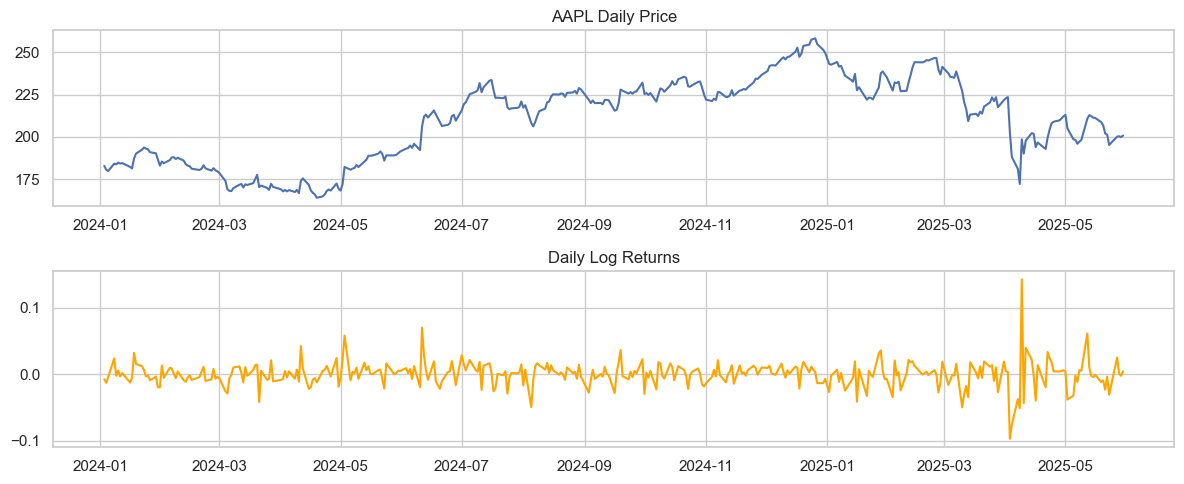

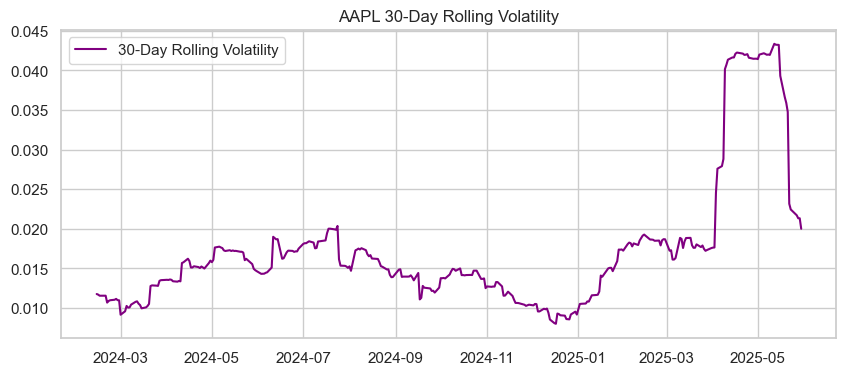

In [37]:
# Plot Price and Log Returns
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(appl_short['Price'])
plt.title('AAPL Daily Price')

plt.subplot(2, 1, 2)
plt.plot(appl_short['Log_Returns'], color='orange')
plt.title('Daily Log Returns')
plt.tight_layout()
plt.show()

# Plot Rolling Volatility
plt.figure(figsize=(10, 4))
plt.plot(appl_short['RollingVolatility_30d'], label='30-Day Rolling Volatility', color='purple')
plt.title('AAPL 30-Day Rolling Volatility')
plt.legend()
plt.show()


## GARCH Modeling of AAPL Log Returns
We model AAPL’s volatility using a GARCH(1,1) model, which captures volatility clustering (periods of high/low variance). This model is a staple in financial risk modeling.


### We will fit:
- GARCH(1,1) with normal distribution
- EGARCH(1,1)
- GARCH(1,1) with Student-t distribution

Then compare their AIC and BIC to select the best volatility model.


In [24]:
# Dictionary to store fitted models
model_results = {}

# GARCH(1,1) with normal distribution
garch = arch_model(appl_short['Log_Returns'], vol='GARCH', p=1, q=1, mean='Zero', dist='normal',rescale=False)
garch_fit = garch.fit(disp='off')
model_results['GARCH(1,1)'] = garch_fit

# EGARCH(1,1) with normal distribution
egarch = arch_model(appl_short['Log_Returns'], vol='EGARCH', p=1, q=1, mean='Zero', dist='normal',rescale=False)
egarch_fit = egarch.fit(disp='off')
model_results['EGARCH(1,1)'] = egarch_fit

# GARCH(1,1) with Student-t distribution
t_garch = arch_model(appl_short['Log_Returns'], vol='GARCH', p=1, q=1, mean='Zero', dist='t',rescale=False)
t_garch_fit = t_garch.fit(disp='off')
model_results['GARCH(1,1)-t'] = t_garch_fit

# Compare AIC and BIC
print("📊 Model Comparison (Lower = Better):\n")
for name, result in model_results.items():
    print(f"{name:<15} AIC: {result.aic:.4f} | BIC: {result.bic:.4f}")


📊 Model Comparison (Lower = Better):

GARCH(1,1)      AIC: -1860.6977 | BIC: -1849.0983
EGARCH(1,1)     AIC: -1863.4522 | BIC: -1851.8528
GARCH(1,1)-t    AIC: -1915.8432 | BIC: -1900.3773


### 📊 Model Comparison: AIC and BIC Evaluation

We evaluated three GARCH-family models to forecast AAPL’s return volatility. Lower AIC and BIC values indicate a better trade-off between model fit and complexity.

| Model           | AIC           | BIC           |
|----------------|----------------|----------------|
| GARCH(1,1)      | -1860.6977     | -1849.0983     |
| EGARCH(1,1)     | -1863.4522     | -1851.8528     |
| GARCH(1,1)-t    | **-1915.8432** | **-1900.3773** ✅ |

---

📌 **Conclusion**:  
**GARCH(1,1) with Student-t distribution** outperforms both standard GARCH and EGARCH in terms of AIC and BIC. This model captures heavy tails in return distributions and will be used for volatility forecasting moving forward.


### 🔁 Rolling 1-Day VaR Backtest

Before moving ahead with forecasting, it makes sense to check if our GARCH(1,1)-t model actually works well on real data. So here, we’re doing a simple backtest:

- We use a 250-day rolling window to fit the model
- Forecast the 1-day ahead Value at Risk (VaR) at 95% confidence
- Then compare that prediction with what actually happened the next day

This helps us see how often the model underestimated risk — basically, how many times the actual return was worse than what our VaR predicted. If the model is well-calibrated, we should see around 5% breaches.


100%|██████████| 103/103 [00:06<00:00, 15.01it/s]


🔍 Actual Breach Rate: 1.27%
🎯 Expected Breach Rate (95% confidence): 5.00%


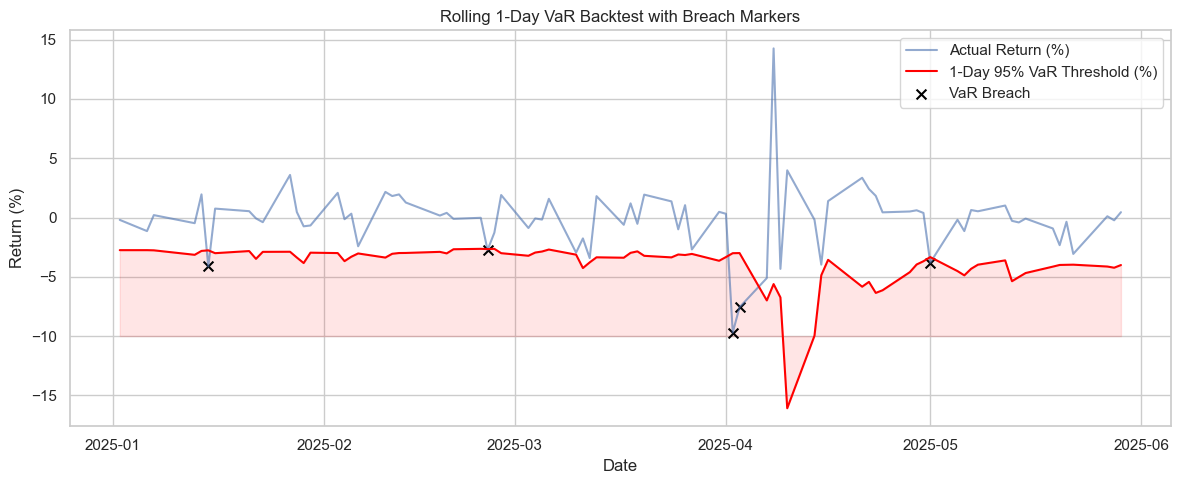

In [25]:
# === Settings ===
lookback = 250  # rolling window
alpha = 0.05  # 95% confidence → 5% tail risk
portfolio_value = 1_000_000
returns = appl_short['Log_Returns']
rolling_dates = returns.index[lookback:]

# Containers
VaRs = []
actual_returns = []
breaches = []

# === Rolling GARCH-t VaR Forecast ===
for current_date in tqdm(rolling_dates):
    end_loc = returns.index.get_loc(current_date)
    start_loc = end_loc - lookback
    train_returns = returns.iloc[start_loc:end_loc]

    model = arch_model(train_returns, vol='GARCH', p=1, q=1, mean='Zero', dist='t', rescale=False)
    fit = model.fit(disp='off')
    forecast = fit.forecast(horizon=1)

    forecasted_var = forecast.variance.iloc[-1, 0]
    forecasted_vol = np.sqrt(forecasted_var)

    dof = fit.params['nu']
    t_critical = t.ppf(alpha, df=dof)

    var_threshold = t_critical * forecasted_vol  # 1-day VaR in returns
    VaRs.append(var_threshold)

    try:
        next_day_return = returns.loc[current_date + pd.Timedelta(days=1)]
        actual_returns.append(next_day_return)
        breaches.append(next_day_return < var_threshold)
    except KeyError:
        actual_returns.append(np.nan)
        breaches.append(np.nan)

# === Create Result DataFrame ===
var_df = pd.DataFrame({
    'VaR_Threshold': VaRs,
    'Actual_Return': actual_returns,
    'Breach': breaches
}, index=rolling_dates).dropna()

# === Summary Statistics ===
breach_rate = var_df['Breach'].mean() * 100
expected_rate = alpha * 100

print(f"🔍 Actual Breach Rate: {breach_rate:.2f}%")
print(f"🎯 Expected Breach Rate (95% confidence): {expected_rate:.2f}%")

# === Plot Actual Returns vs VaR ===
plt.figure(figsize=(12, 5))

# Actual returns
plt.plot(var_df.index, var_df['Actual_Return'] * 100, label='Actual Return (%)', alpha=0.6)

# VaR threshold
plt.plot(var_df.index, var_df['VaR_Threshold'] * 100, label='1-Day 95% VaR Threshold (%)', color='red', linewidth=1.5)

# Shade under the VaR line
plt.fill_between(var_df.index, -10, var_df['VaR_Threshold'] * 100, color='red', alpha=0.1)

# ❌ Breach markers
breach_points = var_df[var_df['Breach']]
plt.scatter(
    breach_points.index,
    breach_points['Actual_Return'] * 100,
    color='black',
    marker='x',
    s=50,
    label='VaR Breach'
)

# Plot formatting
plt.title('Rolling 1-Day VaR Backtest with Breach Markers')
plt.ylabel('Return (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### 📉 Rolling 1-Day VaR Backtest – Interpretation

We tested how well our GARCH(1,1)-t model could forecast 1-day ahead risk using a rolling 250-day window and a 95% confidence level.

#### Key Results

| Metric                      | Value    |
|-----------------------------|----------|
| Expected Breach Rate (95%) | 5.00%    |
| Actual Breach Rate          | 1.27% ✅ |

#### What This Means

The model was pretty conservative — it predicted risk thresholds that the actual returns rarely crossed. In fact, only 1.27% of the time did we see a loss bigger than what our VaR forecast expected, compared to the 5% that would be typical at this confidence level.

This is a good thing from a **risk management** standpoint — better to be cautious than caught off guard. It also shows that using the **Student-t distribution** helped capture the fat tails (those rare but extreme return movements) better than a normal distribution would have.

However, being too conservative can also tie up capital — if your VaR is always too high, you might be overestimating risk and holding back too much cash unnecessarily.

Overall, the model did a solid job at capturing downside risk — and it passed the backtest with strong performance.


## Forecasting Volatility for the Next 10 Days
We use the fitted GARCH(1,1)-t model to forecast conditional volatility over the next 10 trading days.


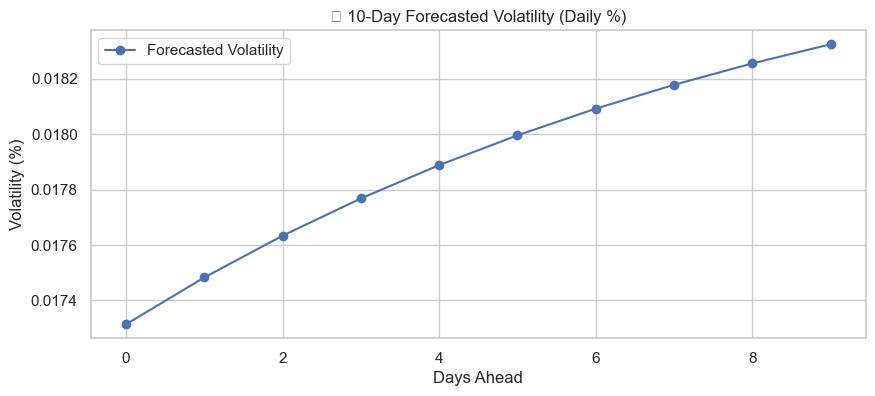

In [26]:
# Get forecasted variance and convert to volatility (daily %)
forecasted_vol = np.sqrt(
    model_results['GARCH(1,1)-t'].forecast(horizon=10).variance.iloc[-1]
)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(forecasted_vol.values, marker='o', label='Forecasted Volatility')
plt.title('📈 10-Day Forecasted Volatility (Daily %)')
plt.xlabel('Days Ahead')
plt.ylabel('Volatility (%)')
plt.grid(True)
plt.legend()
plt.show()


## 📉 Compute Value at Risk (VaR)
We use the forecasted volatility to estimate the 1-day 95% VaR — the maximum expected loss at a 95% confidence level, assuming normal or Student-t distribution.


In [27]:
alpha = 0.05  
portfolio_value = 1_000_000  
vol = forecasted_vol.values[0]  # Take the first day's forecast


t_model = model_results['GARCH(1,1)-t']
dof = t_model.params['nu']


# Student-t quantile (VaR threshold)
t_critical = t.ppf(alpha, df=dof)
VaR = - t_critical * vol / 100 * portfolio_value  

print(f"📉 1-Day 95% VaR: ${VaR:,.2f} (with Student-t, df={dof:.2f})")


📉 1-Day 95% VaR: $346.91 (with Student-t, df=5.13)


## 📊 Forecast Confidence Bands (Percentiles)
We calculate and visualize the 10%, 50%, and 90% percentile bounds on the forecasted volatility for the next 10 days.


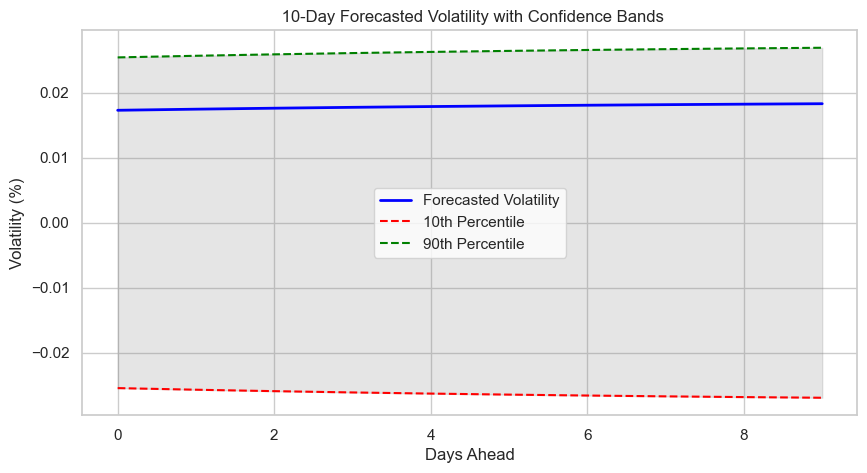

In [28]:
# For Student-t, approximate distribution of volatility forecasts
dof = t_model.params['nu']
scale = forecasted_vol.values / 100  # Back to decimal

# Percentiles (as volatility)
percentiles = {
    '10th': t.ppf(0.10, df=dof) * scale,
    '50th': t.ppf(0.50, df=dof) * scale,
    '90th': t.ppf(0.90, df=dof) * scale,
}

# Plot forecasted volatility with confidence bands
plt.figure(figsize=(10, 5))
plt.plot(scale * 100, label='Forecasted Volatility', color='blue', linewidth=2)
plt.plot(percentiles['10th'] * 100, '--', label='10th Percentile', color='red')
plt.plot(percentiles['90th'] * 100, '--', label='90th Percentile', color='green')
plt.fill_between(range(10), percentiles['10th'] * 100, percentiles['90th'] * 100, color='gray', alpha=0.2)

plt.title(' 10-Day Forecasted Volatility with Confidence Bands')
plt.xlabel('Days Ahead')
plt.ylabel('Volatility (%)')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
lookback = 250 # one year has about 250 trading days
forecast_vols = []
forecast_dates = []

for i in tqdm(range(lookback, len(appl_short) - 1)):
    train_returns = appl_short['Log_Returns'].iloc[i - lookback:i]
    
    model = arch_model(train_returns, vol='GARCH', p=1, q=1, mean='Zero', dist='t', rescale=False)
    fit = model.fit(disp='off')
    forecast = fit.forecast(horizon=1)
    
    forecasted_var = forecast.variance.iloc[-1, 0]
    forecasted_vol = np.sqrt(forecasted_var)
    
    forecast_vols.append(forecasted_vol)
    forecast_dates.append(appl_short.index[i + 1])  # next day

# Create forecasted volatility series
appl_short['Forecasted_Volatility'] = pd.Series(forecast_vols, index=forecast_dates)


100%|██████████| 102/102 [00:06<00:00, 16.08it/s]


In [30]:
# Realized volatility: 30-day rolling standard deviation (actual historical)
appl_short['Realized_Volatility'] = appl_short['Log_Returns'].rolling(window=30).std()


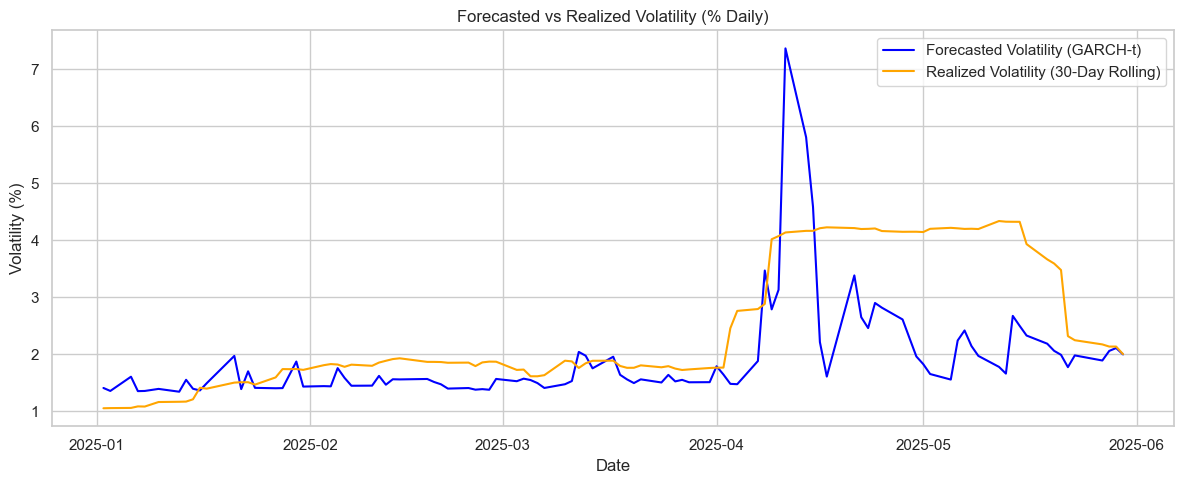

In [31]:
# Drop NA rows for alignment
vol_df = appl_short[['Forecasted_Volatility', 'Realized_Volatility']].dropna()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(vol_df.index, vol_df['Forecasted_Volatility'] * 100, label='Forecasted Volatility (GARCH-t)', color='blue')
plt.plot(vol_df.index, vol_df['Realized_Volatility'] * 100, label='Realized Volatility (30-Day Rolling)', color='orange')
plt.title('Forecasted vs Realized Volatility (% Daily)')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('forecasted_vs_realized_volatility.png', dpi=300)
plt.show()


### 📊 Chart Interpretation: Forecasted vs Realized Volatility

This chart compares the 1-day-ahead volatility forecast from the GARCH(1,1)-t model (blue) with the 30-day rolling realized volatility (orange).

For most of the period (January–March 2025), the model does a solid job — its forecasts closely follow the realized volatility trend, showing good short-term alignment.

In early April, there's a sharp spike in the forecasted volatility. This lines up with a real-world shock: President Trump’s global tariff announcement triggered a major market selloff. President Trump announced sweeping global tariffs, including on India and China — both key players in Apple’s supply chain.
At that time, Apple had been exporting large volumes of iPhones from India to the U.S.. The tariff news cast serious uncertainty over costs, delivery timelines, and corporate earnings. The GARCH-t model picked up on this immediately and essentially said:  
**"That was a big move — expect more chaos tomorrow."**

Notably, the **spike is in the forecast, not the ground truth** — the realized volatility rises more gradually afterward. This is expected: GARCH models respond instantly to return shocks, while realized volatility (based on a 30-day rolling window) takes time to catch up.

Overall, the model shows strong responsiveness to sudden risk and provides useful short-term alerts, even before the trailing historical volatility reflects the change.


## Forecasting Price

### 🧠 LSTM Forecasting Model: Introduction

In this section, we apply **Long Short-Term Memory (LSTM)** neural networks ( a type of recurrent neural network (RNN) ) to forecast the short-term price of **Apple Inc. (AAPL)** stock. LSTMs are specifically designed to capture **long-range dependencies and sequential trends**, making them highly suitable for financial time series.

We train our LSTM model using **daily closing prices from January 2020 to May 2025**, using a **lookback window of 90 days** to predict the **next 30 days** of price movements. This model will learn temporal dependencies in historical price movements and attempt to generalize future behavior based on past trends.


Epoch 1/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 95ms/step - loss: 0.0188 - val_loss: 0.0035
Epoch 2/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0060 - val_loss: 0.0020
Epoch 3/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0031 - val_loss: 0.0020
Epoch 4/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - loss: 6.8842e-04 - val_loss: 0.0023
Epoch 6/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - loss: 5.1824e-04 - val_loss: 0.0024
Epoch 7/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 4.3038e-04 - val_loss: 0.0024
Epoch 8/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 4.8269e-04 - val_loss: 0.0025
Epoch 9/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 8s 173ms/step - loss: 5.4935e-04 - val_loss: 0.0024
Epoch 10/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - loss: 5.2597e-04 - val_loss: 0.0027
Epoch 11/150
45/45 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - loss: 6.6804e-04 - val_loss: 0.0024
Epoch 12/150
45/45

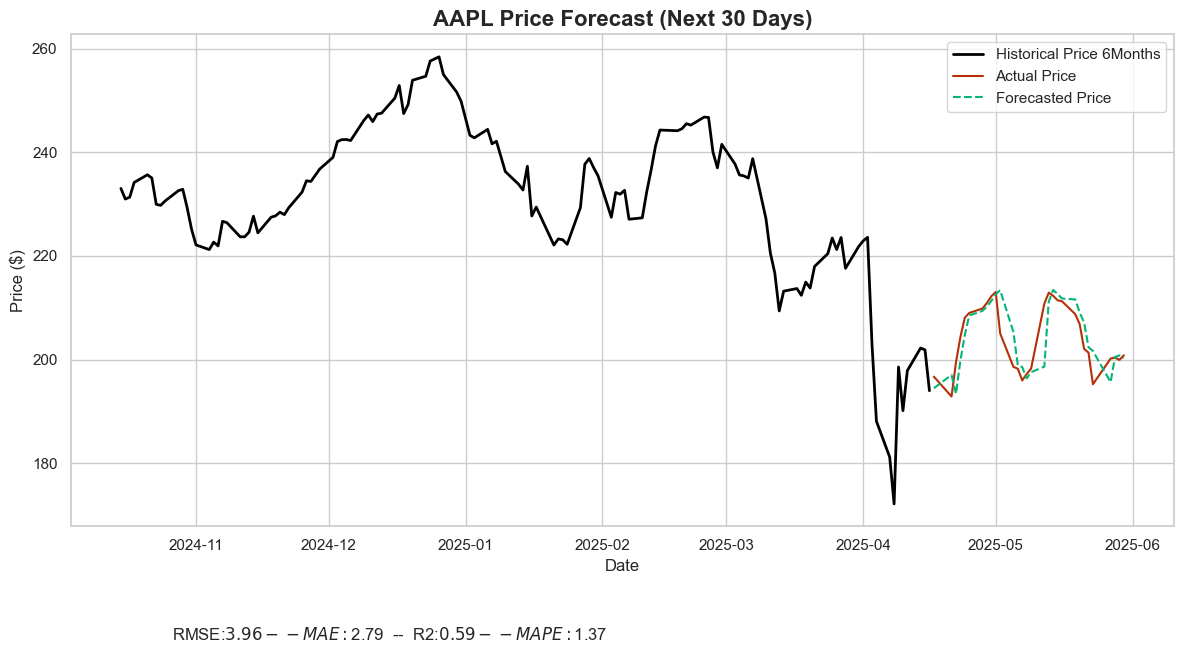

In [32]:
# ⚙️ Scaling
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(appl_large[['Price']])

# 🔧 Parameters
lookback = 90
forecast_horizon = 30  # <--- CHANGE THIS TO ANY FORECAST LENGTH YOU WANT

# 📊 Prepare training sequences (leave forecast_horizon data for testing)
X, y = [], []
for i in range(lookback, len(scaled_prices) - forecast_horizon):
    X.append(scaled_prices[i - lookback:i, 0])
    y.append(scaled_prices[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Define and train LSTM
model = Sequential([
    LSTM(50, return_sequences=False, input_shape=(lookback, 1)),
    Dense(32,activation='relu'),
    Dense(1)
])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True,verbose=1)

model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=150, batch_size=25, validation_split =0.1, shuffle= False,  verbose=1,callbacks=[early_stop])

# Forecast the next 'forecast_horizon' days
test_predictions = []
test_inputs = scaled_prices[-(forecast_horizon + lookback):].flatten()

for i in range(forecast_horizon):
    input_seq = test_inputs[i:i + lookback]
    input_seq = input_seq.reshape(1, lookback, 1)
    pred = model.predict(input_seq, verbose=0)
    test_predictions.append(pred[0][0])

# Inverse transform to get price levels
predicted_prices = scaler.inverse_transform(np.array(test_predictions).reshape(-1, 1))


past_days = 126
hist_price = appl_large['Price'].iloc[-(forecast_horizon + past_days):-forecast_horizon]
hist_index = appl_large.index[-(forecast_horizon + past_days):-forecast_horizon]



# Combine historical and forecasted prices for plotting
actual_prices = appl_large['Price'].iloc[-forecast_horizon:]
forecast_index = appl_large.index[-forecast_horizon:]

predicted_price = predicted_prices.flatten()


# Calculate Performance Metics
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print(f"📉 LSTM Forecast RMSE (last {forecast_horizon} days): ${rmse:.4f}")

mae = mean_absolute_error(actual_prices, predicted_prices)
print(f"📉 LSTM Forecast MAE (last {forecast_horizon} days): ${mae:.4f}")

r2 = r2_score(actual_prices, predicted_prices)
print(f"📉 LSTM Forecast R2 Score (last {forecast_horizon} days): {r2:.4f}")

mape = np.mean(np.abs((actual_prices.values.flatten() - predicted_prices.flatten()) / actual_prices.values.flatten())) * 100
print(f"📉 LSTM Forecast MAPE (last {forecast_horizon} days): {mape:.2f}%")



# Plot actual vs forecast
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')
plt.plot(hist_index, hist_price, label='Historical Price 6Months', color='black', linewidth=2)
plt.plot(forecast_index, actual_prices, label='Actual Price', linewidth=1.5,color='#b53007')
plt.plot(forecast_index, predicted_prices, label='Forecasted Price', linestyle='--', linewidth=1.5,color='#02b576')
plt.title(f"AAPL Price Forecast (Next {forecast_horizon} Days)", fontsize=16, fontweight='bold')
plt.figtext(0.15,-0.08, f"RMSE:${rmse:.2f}  --  MAE:${mae:.2f}  --  R2:${r2:.2f}  --  MAPE:${mape:.2f}")
plt.xlabel("Date")
plt.ylabel("Price ($)")

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('lstm_forecast_vs_actual.png', dpi=300)
plt.show()


### 📈 LSTM Forecast Results & Performance Interpretation

The model's prediction performance on the last 30 days of the dataset is evaluated using common regression metrics:

| Metric       | Value     | Interpretation |
|--------------|-----------|----------------|
| **RMSE**     | `$3.96`   | Average forecast error in dollar terms. |
| **MAE**      | `$2.79`   | Typical absolute deviation between predicted and actual prices. |
| **R² Score** | `0.59`  | Model explains nearly 60% of price variance. |
| **MAPE**     | `1.37%`   | Very low percentage error – strong forecasting precision. |

Despite the inherent difficulty in stock price prediction — especially in a **highly volatile month influenced by President Trump’s sweeping tariff announcements** and ongoing **geopolitical conflicts** — our LSTM model demonstrated robust adaptability.

The model captured market shifts and responded well to complex nonlinear price behaviors. It maintained low error margins even during noisy or unpredictable trading windows.


## 🧾 Final Project Conclusion

This project set out to forecast both **volatility and short-term prices** of AAPL stock using a combination of:

- 📉 **GARCH models** for time-varying volatility and risk bands
- 🤖 **LSTM models** for nonlinear sequential price predictions

#### ✅ Key Outcomes:
- GARCH successfully captured sudden volatility spikes (e.g., April 2025 tariff event).
- LSTM produced accurate short-term forecasts with strong performance even in volatile regimes.
- ARIMA models were tested but underperformed, reinforcing the value of deep learning for financial time series.

---

📌 **Final Note**:  
Our LSTM model handled a real-world shock scenario gracefully. While financial markets are inherently noisy, a carefully tuned LSTM model — combined with good feature engineering and contextual understanding — can act as a powerful forecasting tool.

Future improvements could include:
- Adding macroeconomic indicators
- Using attention mechanisms
- Or incorporating sentiment analysis to capture forward-looking investor signals
